In [49]:
from PIL import Image
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import glob
import math
from matplotlib import cm, pyplot as plt
from matplotlib.collections import RegularPolyCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# prepare dataset

In [2]:
def build_dataset():
    org_dataset = []
    label_list = []
    for i in range(1, 16):
        filelist = glob.glob('yalefaces/subject'+str(i).zfill(2)+"*")
        for fname in filelist:
            img = np.array(Image.open(fname))
            img = img.reshape(img.shape[0]*img.shape[1])
            org_dataset.append(img)
            label_list.append(fname[20:])
    org_dataset = np.array(org_dataset)
    
    return org_dataset,label_list

org_dataset,labels = build_dataset()
num_components = len(org_dataset)

# SOM implmentation

In [293]:
class SOM(object):

    def __init__(self, map_size, lr=1, radius=10, type_neighber_fun="gaussian_neighber", not_load=True):
        
        self.map = np.random.random(size = (map_size[0], map_size[1], map_size[2]))*255 if not_load else None
        #np.random.seed(42)
        self.lr0 = lr
        self.lr = self.lr0

        self.R0 = radius
        self.R = self.R0
        
        self.type_neighber_fun = type_neighber_fun

    def train(self, X, T=1000):
        
        Js = []
        for t in range(T):
            prev_map = self.map
            shuffle_ind = np.random.randint(low = 0, high = len(X), size = len(X))
                
            for i in range(len(X)):
                x = X[shuffle_ind[i], :]

                winner = self.find_winner(x)
                
                if self.type_neighber_fun == "no_neighber":
                    NS = 0
                else:
                    NS = self.get_NS2(winner)
                
                       
                self.update_weights(x, NS, len(X))

                
            #self.lr = self.lr0 * (1 - t/T)
            #self.R = self.R0 * (1 - t/T)
            
            self.lr = self.lr0 * np.exp(-t/T)
            self.R = self.R0 * np.exp(-t/T)
            
            new_map = np.linalg.norm(prev_map - self.map)
            Js.append(new_map)
            
            if t % 1 == 0:
                print("Itration: %d, LR: %f, R: %f, J: %f" %(t, self.lr, self.R, Js[-1]))

        return Js


    def find_winner(self, x):
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        dists = np.sum((self.map - rep_x)**2, axis = 2)
        winner = np.unravel_index(np.argmin(dists, axis = None), dists.shape)
        return winner

    
    #plus neighberhood
    def get_NS(self, winner):
        NS = np.zeros(shape = (self.map.shape[0], self.map.shape[1]))
        iw, jw = winner[0], winner[1]

        NS[iw, jw] = 1

        for r in range(1, int(self.R)):

            if iw - r >= 0:
                NS[iw - r, jw] = self.gaussian_update_NS(self.dist_win(winner, (iw - r, jw)), r) if self.type_neighber_fun == "gaussian_neighber" else 1/r
            if iw + r < self.map.shape[0] - 1:
                NS[iw + r, jw] = self.gaussian_update_NS(self.dist_win(winner, (iw + r, jw)), r) if self.type_neighber_fun == "gaussian_neighber" else 1/r
            
            if jw - r >= 0:
                NS[iw, jw - r] = self.gaussian_update_NS(self.dist_win(winner, (iw, jw - r)), r) if self.type_neighber_fun == "gaussian_neighber" else 1/r
            if jw + r < self.map.shape[1] - 1:
                NS[iw, jw + r] = self.gaussian_update_NS(self.dist_win(winner, (iw, jw + r)), r) if self.type_neighber_fun == "gaussian_neighber" else 1/r

        return NS
    
    def gaussian_update_NS(self, dist_win, r):
        return np.exp(- np.square(dist_win) / 2 * np.square(r))
    
    #gaussian neighberhood
    def get_NS3(self, winner):
        
        win_matrix = np.tile(winner, (self.map.shape[0] * self.map.shape[1], 1))
        map_neuron = []
        
        for i in range(self.map.shape[0]):
            for j in range(self.map.shape[1]):
                map_neuron.append(np.array([i, j]))
        
        map_neuron = np.array(map_neuron)
        dists_neurons = np.array(np.sum(np.square(win_matrix - map_neuron), 1)).reshape(self.map.shape[0], self.map.shape[1])
                
        return np.exp(- np.square(dists_neurons) / (2 * np.square(self.R)))
    
    #circle neighberhood
    def get_NS2(self, winner):
        NS = np.zeros(shape = (self.map.shape[0], self.map.shape[1]))
        iw, jw = winner[0], winner[1]
        
        NS[iw, jw] = 1
        
        R = int(self.R)
        for ri in range(-R, R):
            for rj in range(-R, R):
                if(0 <= iw + ri < self.map.shape[0]) and(0 <= jw + rj < self.map.shape[1]):
                    NS[iw + ri, jw + rj] = 0 if np.sqrt(np.square(ri) + np.square(rj)) > R else self.gaussian_update_NS(self.dist_win(winner, (iw + rj, jw + rj)), ri) if self.type_neighber_fun == "gaussian_neighber" else np.sqrt(np.square(ri) + np.square(rj))
                    #self.gaussian_update_NS(self.dist_win(winner, (iw + rj, jw + rj)), ri) 
                    
        return NS
                        
    def dist_win(self, winner, neuron):
        return np.sum(np.square(np.array(winner) - np.array(neuron)))

    def update_weights(self, x, n_strength, X_len):

        NS = np.tile(n_strength, [self.map.shape[2], 1, 1]).transpose()
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        Delta = rep_x - self.map
        
        if self.type_neighber_fun == "no_neighber":
            self.map = self.map + (self.lr / X_len) * Delta
        else:
            self.map = self.map + (self.lr / X_len) * np.multiply(NS, Delta)
        
        
    def feature_extraction(self, x):
        rep_x = np.tile(x, [self.map.shape[0], self.map.shape[1], 1])
        dists = np.sum((self.map - rep_x)**2, axis = 2)
        return 1 / (1 + dists)
    

        return NS
    
    def labels_map(self, data, labels):
        
        winmap = defaultdict(list)
        print(winmap)
        for x, l in zip(data, labels):
            winmap[tuple(self.find_winner(x))].append(l)
        for position in winmap:
            winmap[position] = Counter(winmap[position])
        return winmap
    
    def purity(self, data, label):
        
        purit_matrix = np.zeros(shape = (self.map.shape[0], self.map.shape[1]))
        labels_map = self.labels_map(data, label)
        label_names = np.unique(label)

        total = []
        for position in labels_map.keys():
            label_fracs = [labels_map[position][l] for l in label_names]
            total.append(label_fracs)
            
            
        for i, position in enumerate(labels_map.keys()):

            p_x, p_y = position[0], position[1]
            purit_matrix[p_x][p_y] = max(total[i]) / sum(total[i])
            
    
        return ((np.sum(purit_matrix)) / (len(labels_map.keys()))) , ((self.map.shape[0]*self.map.shape[1]) - len(labels_map.keys()))
    
    
    def get_weights(self):
        return self.map
    
    def visualize(self, X, y):
        pass
    
    def distance_map(self):
        
        we = self.get_weights()
        um = np.zeros((we.shape[0], we.shape[1]))
        it = np.nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if (ii >= 0 and ii < we.shape[0] and
                            jj >= 0 and jj < we.shape[1]):
                        w_1 = we[ii, jj, :]
                        w_2 = we[it.multi_index]
                        w_f = w_1 - w_2
                        um[it.multi_index] += np.sqrt(np.dot(w_f, w_f.T))
            it.iternext()
        um = um/um.max()
        return um
    
    def load_weights(self, weights):
        self.map = weights
    

# Question 3

In [356]:
som_shape = (4,4)
som = SOM(map_size = [som_shape[0], som_shape[1], org_dataset.shape[1]], lr= 0.0001, radius= 3)
Js = som.train(org_dataset, T=25)
             
purity , deads = som.purity(org_dataset, labels)
print('purity:' + str(purity))


Itration: 0, LR: 0.000100, R: 3.000000, J: 5.871316
Itration: 1, LR: 0.000096, R: 2.882368, J: 5.782735
Itration: 2, LR: 0.000092, R: 2.769349, J: 4.526142
Itration: 3, LR: 0.000089, R: 2.660761, J: 4.405594
Itration: 4, LR: 0.000085, R: 2.556431, J: 4.119116
Itration: 5, LR: 0.000082, R: 2.456192, J: 3.998893
Itration: 6, LR: 0.000079, R: 2.359884, J: 3.926038
Itration: 7, LR: 0.000076, R: 2.267351, J: 3.754877
Itration: 8, LR: 0.000073, R: 2.178447, J: 3.770675
Itration: 9, LR: 0.000070, R: 2.093029, J: 3.620154
Itration: 10, LR: 0.000067, R: 2.010960, J: 3.515940
Itration: 11, LR: 0.000064, R: 1.932109, J: 3.307013
Itration: 12, LR: 0.000062, R: 1.856350, J: 1.929445
Itration: 13, LR: 0.000059, R: 1.783562, J: 1.789718
Itration: 14, LR: 0.000057, R: 1.713627, J: 1.708896
Itration: 15, LR: 0.000055, R: 1.646435, J: 1.587027
Itration: 16, LR: 0.000053, R: 1.581877, J: 1.700166
Itration: 17, LR: 0.000051, R: 1.519851, J: 1.483073
Itration: 18, LR: 0.000049, R: 1.460257, J: 1.545019
Itr

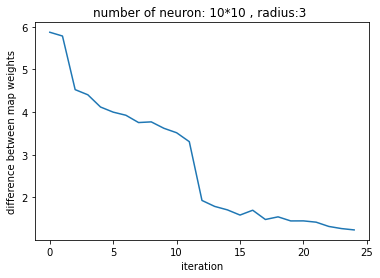

In [357]:
plt.title('number of neuron: 10*10 , radius:3 ')
plt.xlabel('iteration')
plt.ylabel('difference between map weights')
plt.plot(Js)
plt.show()

# Question 4

In [358]:
def plot_hex_map(d_matrix, titles=[], colormap=cm.gray, shape=[1, 1], comp_width=5, hex_shrink=1.0, fig=None,
                 colorbar=True):
    

    d_matrix = np.flip(d_matrix, axis=0)

    def create_grid_coordinates(x, y):
        coordinates = [x for row in -1 * np.array(list(range(x))) for x in
                       list(zip(np.arange(((row) % 2) * 0.5, y + ((row) % 2) * 0.5), [0.8660254 * (row)] * y))]
        return (np.array(list(reversed(coordinates))), x, y)

    if d_matrix.ndim < 3:
        d_matrix = np.expand_dims(d_matrix, 2)

    if len(titles) != d_matrix.shape[2]:
        titles = [""] * d_matrix.shape[2]

    n_centers, x, y = create_grid_coordinates(*d_matrix.shape[:2])

    # Size of figure in inches
    if fig is None:
        xinch, yinch = comp_width * shape[1], comp_width * (x / y) * shape[0]
        fig = plt.figure(figsize=(xinch, yinch), dpi=72.)

    for comp, title in zip(range(d_matrix.shape[2]), titles):
        ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')

        # Get pixel size between two data points
        xpoints = n_centers[:, 0]
        ypoints = n_centers[:, 1]
        ax.scatter(xpoints, ypoints, s=0.0, marker='s')
        ax.axis([min(xpoints) - 1., max(xpoints) + 1.,
                 min(ypoints) - 1., max(ypoints) + 1.])
        xy_pixels = ax.transData.transform(np.vstack([xpoints, ypoints]).T)
        xpix, ypix = xy_pixels.T

        # discover radius and hexagon
        apothem = hex_shrink * (xpix[1] - xpix[0]) / math.sqrt(3)
        area_inner_circle = math.pi * (apothem ** 2)
        dm = d_matrix[:, :, comp].reshape(np.multiply(*d_matrix.shape[:2]))
        collection_bg = RegularPolyCollection(
            numsides=6,  # a hexagon
            rotation=0,
            sizes=(area_inner_circle,),
            array=dm,
            cmap=colormap,
            offsets=n_centers,
            transOffset=ax.transData,
        )
        ax.add_collection(collection_bg, autolim=True)

        ax.axis('off')
        ax.autoscale_view()
        #, fontdict={"fontsize": 3 * comp_width})
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(collection_bg, cax=cax)
        if not colorbar:
            cbar.remove()

        #cbar.ax.tick_params(labelsize=3 * comp_width)

    return ax, list(reversed(n_centers))

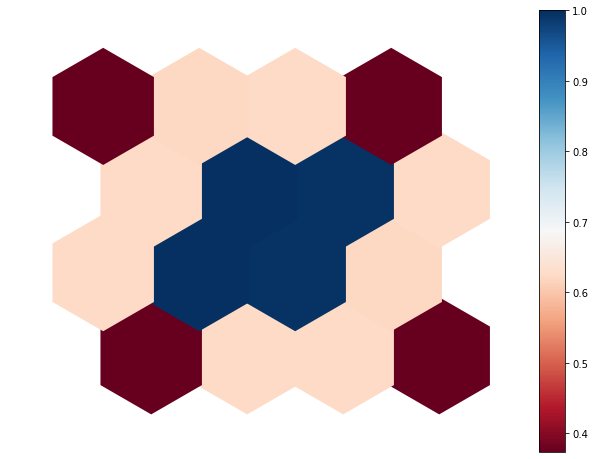

In [359]:
mp = som.distance_map()
ax,L = plot_hex_map(mp, comp_width=10, colormap='RdBu')

defaultdict(<class 'list'>, {})


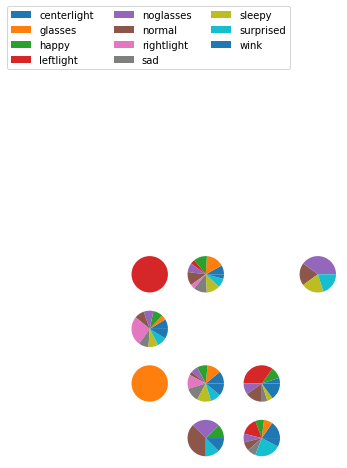

In [360]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

label = labels
labels_map = som.labels_map(org_dataset, label)
#labels_map = label_map
label_names = np.unique(label)

plt.figure(figsize=(40, 40))
the_grid = GridSpec(40, 40)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    #print(label_fracs)
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names, bbox_to_anchor=(0., 6.5), ncol=3)

plt.show()

defaultdict(<class 'list'>, {})


<Figure size 2160x2160 with 0 Axes>

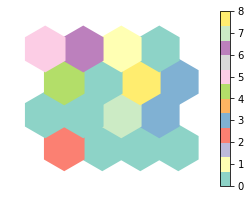

In [361]:
label = labels
labels_map = som.labels_map(org_dataset, label)
label_names = np.unique(label)

plt.figure(figsize=(30, 30))
the_grid = GridSpec(30, 30)
total = []
for position in labels_map.keys():

    label_fracs = [labels_map[position][l] for l in label_names]
    total.append(label_fracs)
    
    
matrix_label = np.zeros((4,4))


for i, position in enumerate(labels_map.keys()):

    p_x = position[0]
    p_y = position[1]
    matrix_label[p_x][p_y] = max(total[i])

ax, centr = plot_hex_map(matrix_label,'label-matrix', comp_width=4, colormap='Set3')

# Question 5

In [331]:
inp_features = []
for i in range(org_dataset.shape[0]):
    feature = np.reshape(som.feature_extraction(org_dataset[i, :]).flatten(),(1, som_shape[0] * som_shape[1]))
    inp_features.append(feature)
    
inp_data = np.array(inp_features)
inp_data = np.reshape(inp_data, (inp_data.shape[0], inp_data.shape[2]))

In [332]:
int_labels = []
for el in labels:
    if el == 'centerlight':
        int_labels.append(0)
    elif el ==  'glasses':
        int_labels.append(1)
        
    elif el ==  'happy':
        int_labels.append(2)

    elif el ==  'leftlight':
        int_labels.append(3)
        
    elif el ==   'noglasses':
        int_labels.append(4)
        
    elif el ==  'normal':
        int_labels.append(5)
        
    elif el ==  'rightlight':
        int_labels.append(6)
        
    elif el ==  'sad':
        int_labels.append(7)
        
    elif el ==  'sleepy':
        int_labels.append(8)
        
    elif el ==  'surprised':
        int_labels.append(9)
        
    elif el ==  'wink':
        int_labels.append(10)

In [333]:
X_train, X_test, Y_train, Y_test = train_test_split(inp_data,int_labels, test_size = .1, random_state = 7)
x_train, x_test, y_train, y_test = train_test_split(org_dataset,int_labels, test_size = .1, random_state = 7)

In [335]:
def log_confusion_matrix(epoch, logs):

    pred = model.predict([X_test, Y_test])
  # Calculate the confusion matrix.
  #cm = confusion_matrix(test_labels, test_pred)
    cm = confusion_matrix(Y_test, pred.round())
  # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names = class_names)
    m_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [336]:
def plot_confusion_matrix(cm, class_names):
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [337]:
tb_callback = keras.callbacks.TensorBoard(log_dir = "./logs", histogram_freq = 1)
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

# with dimension reduction

In [338]:
all_dists = []
for i in range(org_dataset.shape[0]):
    x = org_dataset[i]     
    rep_x = np.tile(x, [som.get_weights().shape[0], som.get_weights().shape[1], 1])
    dists = np.sum((som.get_weights() - rep_x)**2, axis = 2)
    all_dists.append(np.ravel(dists))
    
all_dists = np.array(all_dists)

In [339]:
inp = keras.Input(shape = (all_dists.shape[1] ,), name = "input_layer")
x = keras.layers.Dense(units = 1024, input_dim = all_dists.shape[1], activation = "relu", name = "hidden_layer1")(inp)
x = keras.layers.Dense(units = 11, activation = "softmax", name = "output_layer")(x)
model = keras.Model(inputs = inp, outputs = x)

optimizer = keras.optimizers.Adam(learning_rate= 0.0001)

model.compile(optimizer= optimizer,
             loss= "sparse_categorical_crossentropy",
             metrics= ['accuracy'])

In [340]:
x_train, x_test, y_train, y_test = train_test_split(all_dists,int_labels, test_size = .1, random_state = 7)
y_train= np.array(y_train)
model.fit(x_train, y_train, epochs= 10, validation_split= .2)

Epoch 1/10
4/4 [==============================] - 0s 40ms/step - loss: 433116358.4000 - accuracy: 0.1322 - val_loss: 467038496.0000 - val_accuracy: 0.1000
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 315851891.2000 - accuracy: 0.0901 - val_loss: 291446272.0000 - val_accuracy: 0.0333
Epoch 3/10
4/4 [==============================] - 0s 13ms/step - loss: 202904860.8000 - accuracy: 0.0714 - val_loss: 233770992.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: 155408419.2000 - accuracy: 0.0824 - val_loss: 169316624.0000 - val_accuracy: 0.1333
Epoch 5/10
4/4 [==============================] - 0s 12ms/step - loss: 116854019.2000 - accuracy: 0.0733 - val_loss: 106615032.0000 - val_accuracy: 0.1000
Epoch 6/10
4/4 [==============================] - 0s 13ms/step - loss: 66812916.0000 - accuracy: 0.0949 - val_loss: 60678236.0000 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 12ms/step -

In [341]:
y_test= np.array(y_test)
model.evaluate(x_test, y_test, verbose=2)

1/1 - 0s - loss: 34168504.0000 - accuracy: 0.1765


[34168504.0, 0.1764705926179886]

# without dimension reduction

In [325]:
inp = keras.Input(shape = (org_dataset.shape[1],), name = "input_layer")
x = keras.layers.Dense(units = 1024, input_dim = org_dataset.shape[1], activation = "relu", name = "hidden_layer1")(inp)
x = keras.layers.Dense(units = 11, activation = "softmax", name = "output_layer")(x)
model = keras.Model(inputs = inp, outputs = x)

optimizer = keras.optimizers.Adam(learning_rate= 0.0001)

model.compile(optimizer= optimizer,
             loss= "sparse_categorical_crossentropy",
             metrics= ['accuracy'])

In [326]:
x_train, x_test, y_train, y_test = train_test_split(org_dataset,int_labels, test_size = .1, random_state = 7)
y_train= np.array(y_train)
model.fit(x_train, y_train, epochs= 10, validation_split= .2)

Epoch 1/10
4/4 [==============================] - 2s 493ms/step - loss: 3562.1562 - accuracy: 0.0439 - val_loss: 7252.9707 - val_accuracy: 0.1000
Epoch 2/10
4/4 [==============================] - 2s 434ms/step - loss: 10590.7076 - accuracy: 0.0544 - val_loss: 6416.2983 - val_accuracy: 0.1333
Epoch 3/10
4/4 [==============================] - 2s 452ms/step - loss: 9434.0717 - accuracy: 0.1087 - val_loss: 4875.3906 - val_accuracy: 0.1667
Epoch 4/10
4/4 [==============================] - 2s 429ms/step - loss: 5181.8892 - accuracy: 0.1660 - val_loss: 2465.1960 - val_accuracy: 0.1333
Epoch 5/10
4/4 [==============================] - 2s 451ms/step - loss: 2579.6227 - accuracy: 0.1880 - val_loss: 1753.5779 - val_accuracy: 0.1667
Epoch 6/10
4/4 [==============================] - 2s 431ms/step - loss: 1215.9810 - accuracy: 0.2078 - val_loss: 1387.6078 - val_accuracy: 0.1333
Epoch 7/10
4/4 [==============================] - 2s 430ms/step - loss: 1041.5331 - accuracy: 0.2463 - val_loss: 1193.2738 

In [327]:
y_test= np.array(y_test)
model.evaluate(x_test, y_test, verbose=2)

1/1 - 0s - loss: 610.3569 - accuracy: 0.1176


[610.35693359375, 0.11764705926179886]